### ResNET is able to outform the CNN model on classification by providing Residual Networks that introduces shortcut connections.
- The problem with deeper network is the issue with degradation, and such degradation is not caused by overfitting as adding more layers to a suitably deep model leads to higher training errors
- The solution provided by ResNET is to have added layers that are identity mapping where other layers are copied from the learned shallower model
- It is also proven that by using deeper ResNET, the error rate decreases.
- It is also showned that adding deeper layer such as the model with 1202 layers, even though it shows that the error increases as compared to the one with 110 layers, it was shown in the graph that the training error is similar when comparing the 110 layers and the 1202 layers, showing that the model could have reach a overfitting situation.

In [60]:
import torch
from torchsummary import summary
from torch import nn

In [61]:
import torchvision.transforms as transforms

In [62]:
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, downsample):
        super().__init__()
        if downsample:
            self.conv1 = nn.Conv2d(
                in_channels, out_channels, kernel_size=3, stride=1, padding=1)
            self.shortcut = nn.Sequential(      # shortcut
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.conv1 = nn.Conv2d(
                in_channels, out_channels, kernel_size=3, stride=1, padding=1)
            self.shortcut = nn.Sequential()

        self.conv2 = nn.Conv2d(out_channels, out_channels,
                               kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, input):
        shortcut = self.shortcut(input)
        input = nn.ReLU()(self.bn1(self.conv1(input)))
        input = nn.ReLU()(self.bn2(self.conv2(input)))
        input = input + shortcut
        return nn.ReLU()(input)

#### ResBlock contains downsampling where the shortcut is created to contain 1x1 convolution so it skips some of the layers while retaining the identity function

In [63]:
class ResBottleneckBlock(nn.Module):
    def __init__(self, in_channels, out_channels, downsample):
        super().__init__()
        self.downsample = downsample # for shortcut
        self.conv1 = nn.Conv2d(in_channels, out_channels//4, # 1x1
                               kernel_size=1, stride=1) # 1x1
        self.conv2 = nn.Conv2d( # 3x3
            out_channels//4, out_channels//4, kernel_size=3, stride=2 if downsample else 1, padding=1)
        self.conv3 = nn.Conv2d(out_channels//4, out_channels, kernel_size=1, stride=1) #  1x1

        if self.downsample or in_channels != out_channels: # shortcut
            self.shortcut = nn.Sequential( # 1x1
                nn.Conv2d(in_channels, out_channels, kernel_size=1,
                          stride=2 if self.downsample else 1),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.shortcut = nn.Sequential()

        self.bn1 = nn.BatchNorm2d(out_channels//4)
        self.bn2 = nn.BatchNorm2d(out_channels//4)
        self.bn3 = nn.BatchNorm2d(out_channels)

    def forward(self, input):
        shortcut = self.shortcut(input)
        input = nn.ReLU()(self.bn1(self.conv1(input)))
        input = nn.ReLU()(self.bn2(self.conv2(input)))
        input = nn.ReLU()(self.bn3(self.conv3(input)))
        input = input + shortcut
        return nn.ReLU()(input)

In [64]:
class ResNet(nn.Module):
    def __init__(self, in_channels, resblock, repeat, useBottleneck=False, outputs=7):
        super().__init__()
        self.layer0 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        if useBottleneck:
            filters = [64, 256, 512, 1024, 2048]
        else:
            filters = [64, 64, 128, 256, 512]

        self.layer1 = nn.Sequential()
        self.layer1.add_module('conv2_1', resblock(filters[0], filters[1], downsample=False))
        for i in range(1, repeat[0]):
                self.layer1.add_module('conv2_%d'%(i+1,), resblock(filters[1], filters[1], downsample=False))

        self.layer2 = nn.Sequential()
        self.layer2.add_module('conv3_1', resblock(filters[1], filters[2], downsample=True))
        for i in range(1, repeat[1]):
                self.layer2.add_module('conv3_%d' % (
                    i+1,), resblock(filters[2], filters[2], downsample=False))

        self.layer3 = nn.Sequential()
        self.layer3.add_module('conv4_1', resblock(filters[2], filters[3], downsample=True))
        for i in range(1, repeat[2]):
            self.layer3.add_module('conv2_%d' % (
                i+1,), resblock(filters[3], filters[3], downsample=False))

        self.layer4 = nn.Sequential()
        self.layer4.add_module('conv5_1', resblock(filters[3], filters[4], downsample=True))
        for i in range(1, repeat[3]):
            self.layer4.add_module('conv3_%d'%(i+1,),resblock(filters[4], filters[4], downsample=False))

        self.gap = torch.nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
             torch.nn.Linear(filters[4], outputs),
             torch.nn.Softmax()
        )
        self.transform = transforms.Compose([
        transforms.Grayscale(),
        transforms.Resize((48, 48)),
        transforms.Normalize((0.5,), (0.5,))
        ])
        
    def forward(self, input):
        input = self.transform(input)
        input = self.layer0(input)
        input = self.layer1(input)
        input = self.layer2(input)
        input = self.layer3(input)
        input = self.layer4(input)
        input = self.gap(input)
        # torch.flatten()
        # https://stackoverflow.com/questions/60115633/pytorch-flatten-doesnt-maintain-batch-size
        input = torch.flatten(input, start_dim=1)
        input = self.fc(input)

        return input

In [65]:
resnet18 = ResNet(1, ResBlock, [2, 2, 2, 2], useBottleneck=False, outputs=7)
resnet18.to(torch.device("cuda:0" if torch.cuda.is_available() else "cpu"))
summary(resnet18, (3, 48, 48))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 48, 48]             640
         MaxPool2d-2           [-1, 64, 24, 24]               0
       BatchNorm2d-3           [-1, 64, 24, 24]             128
              ReLU-4           [-1, 64, 24, 24]               0
            Conv2d-5           [-1, 64, 24, 24]          36,928
       BatchNorm2d-6           [-1, 64, 24, 24]             128
            Conv2d-7           [-1, 64, 24, 24]          36,928
       BatchNorm2d-8           [-1, 64, 24, 24]             128
          ResBlock-9           [-1, 64, 24, 24]               0
           Conv2d-10           [-1, 64, 24, 24]          36,928
      BatchNorm2d-11           [-1, 64, 24, 24]             128
           Conv2d-12           [-1, 64, 24, 24]          36,928
      BatchNorm2d-13           [-1, 64, 24, 24]             128
         ResBlock-14           [-1, 64,

d:\Python\Python310\lib\site-packages\torch\nn\modules\container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


### Training and testing the data using ResNet18

In [66]:
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor


In [67]:
# load data from data folder
training_data = datasets.ImageFolder(root='train', transform=ToTensor())
test_data = datasets.ImageFolder(root='test', transform=ToTensor())



In [68]:
# create data loaders
batch_size = 256
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle= True)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break



Shape of X [N, C, H, W]: torch.Size([256, 3, 48, 48])
Shape of y: torch.Size([256]) torch.int64


In [69]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from tqdm.notebook import tqdm

# Define the training function
def train(train_loader, model, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    pbar = tqdm(total=28709//256 + 1)
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        pbar.update(1)
    pbar.close()
    print('loss: %.3f' % (running_loss / len(train_loader)))
    return running_loss / len(train_loader)

# Define the testing function
def test(test_loader, model, loss_fn, device):
    model.eval()
    correct = 0
    total = 0
    test_loss = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            test_loss += loss_fn(outputs, labels).item()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()   
             
    test_loss /= len(test_loader.dataset)
    print(f"Test Error: \n Accuracy: {(100 * correct / total):.2f}%, Avg loss: {test_loss:.2f} \n")
    return (correct / total)*100

In [70]:
model = resnet18
# Define the device (CPU or GPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Optimizing the model parameters
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)


In [71]:
test_accuracies = []
# Training and testing the model
epochs = 64
best_acc = 0
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train(train_dataloader, model, loss_fn, optimizer, device)
    acc = test(test_dataloader, model, loss_fn, device)
    test_accuracies.append(acc)    
    if acc > best_acc:
        # save the state dictionary of the model's weights and other parameters to a file
        torch.save(model.state_dict(), 'model resnet 18 new.pth')
        print('saved')
        best_acc = acc

Epoch 1
-------------------------------


  0%|          | 0/113 [00:00<?, ?it/s]

loss: 1.820
Test Error: 
 Accuracy: 32.98%, Avg loss: 0.01 

saved
Epoch 2
-------------------------------


  0%|          | 0/113 [00:00<?, ?it/s]

loss: 1.713
Test Error: 
 Accuracy: 42.73%, Avg loss: 0.01 

saved
Epoch 3
-------------------------------


  0%|          | 0/113 [00:00<?, ?it/s]

loss: 1.665
Test Error: 
 Accuracy: 41.03%, Avg loss: 0.01 

Epoch 4
-------------------------------


  0%|          | 0/113 [00:00<?, ?it/s]

loss: 1.633
Test Error: 
 Accuracy: 46.39%, Avg loss: 0.01 

saved
Epoch 5
-------------------------------


  0%|          | 0/113 [00:00<?, ?it/s]

loss: 1.609
Test Error: 
 Accuracy: 45.93%, Avg loss: 0.01 

Epoch 6
-------------------------------


  0%|          | 0/113 [00:00<?, ?it/s]

loss: 1.583
Test Error: 
 Accuracy: 48.20%, Avg loss: 0.01 

saved
Epoch 7
-------------------------------


  0%|          | 0/113 [00:00<?, ?it/s]

loss: 1.564
Test Error: 
 Accuracy: 39.12%, Avg loss: 0.01 

Epoch 8
-------------------------------


  0%|          | 0/113 [00:00<?, ?it/s]

loss: 1.543
Test Error: 
 Accuracy: 32.11%, Avg loss: 0.01 

Epoch 9
-------------------------------


  0%|          | 0/113 [00:00<?, ?it/s]

loss: 1.523
Test Error: 
 Accuracy: 53.52%, Avg loss: 0.01 

saved
Epoch 10
-------------------------------


  0%|          | 0/113 [00:00<?, ?it/s]

loss: 1.512
Test Error: 
 Accuracy: 51.78%, Avg loss: 0.01 

Epoch 11
-------------------------------


  0%|          | 0/113 [00:00<?, ?it/s]

loss: 1.488
Test Error: 
 Accuracy: 54.51%, Avg loss: 0.01 

saved
Epoch 12
-------------------------------


  0%|          | 0/113 [00:00<?, ?it/s]

loss: 1.472
Test Error: 
 Accuracy: 50.86%, Avg loss: 0.01 

Epoch 13
-------------------------------


  0%|          | 0/113 [00:00<?, ?it/s]

loss: 1.453
Test Error: 
 Accuracy: 54.58%, Avg loss: 0.01 

saved
Epoch 14
-------------------------------


  0%|          | 0/113 [00:00<?, ?it/s]

loss: 1.434
Test Error: 
 Accuracy: 52.49%, Avg loss: 0.01 

Epoch 15
-------------------------------


  0%|          | 0/113 [00:00<?, ?it/s]

loss: 1.421
Test Error: 
 Accuracy: 53.65%, Avg loss: 0.01 

Epoch 16
-------------------------------


  0%|          | 0/113 [00:00<?, ?it/s]

loss: 1.403
Test Error: 
 Accuracy: 53.39%, Avg loss: 0.01 

Epoch 17
-------------------------------


  0%|          | 0/113 [00:00<?, ?it/s]

loss: 1.387
Test Error: 
 Accuracy: 56.44%, Avg loss: 0.01 

saved
Epoch 18
-------------------------------


  0%|          | 0/113 [00:00<?, ?it/s]

loss: 1.381
Test Error: 
 Accuracy: 52.35%, Avg loss: 0.01 

Epoch 19
-------------------------------


  0%|          | 0/113 [00:00<?, ?it/s]

loss: 1.371
Test Error: 
 Accuracy: 58.43%, Avg loss: 0.01 

saved
Epoch 20
-------------------------------


  0%|          | 0/113 [00:00<?, ?it/s]

loss: 1.356
Test Error: 
 Accuracy: 58.46%, Avg loss: 0.01 

saved
Epoch 21
-------------------------------


  0%|          | 0/113 [00:00<?, ?it/s]

loss: 1.342
Test Error: 
 Accuracy: 56.28%, Avg loss: 0.01 

Epoch 22
-------------------------------


  0%|          | 0/113 [00:00<?, ?it/s]

loss: 1.331
Test Error: 
 Accuracy: 58.37%, Avg loss: 0.01 

Epoch 23
-------------------------------


  0%|          | 0/113 [00:00<?, ?it/s]

loss: 1.329
Test Error: 
 Accuracy: 60.85%, Avg loss: 0.01 

saved
Epoch 24
-------------------------------


  0%|          | 0/113 [00:00<?, ?it/s]

loss: 1.327
Test Error: 
 Accuracy: 57.33%, Avg loss: 0.01 

Epoch 25
-------------------------------


  0%|          | 0/113 [00:00<?, ?it/s]

loss: 1.317
Test Error: 
 Accuracy: 56.59%, Avg loss: 0.01 

Epoch 26
-------------------------------


  0%|          | 0/113 [00:00<?, ?it/s]

loss: 1.312
Test Error: 
 Accuracy: 55.61%, Avg loss: 0.01 

Epoch 27
-------------------------------


  0%|          | 0/113 [00:00<?, ?it/s]

loss: 1.305
Test Error: 
 Accuracy: 56.46%, Avg loss: 0.01 

Epoch 28
-------------------------------


  0%|          | 0/113 [00:00<?, ?it/s]

loss: 1.297
Test Error: 
 Accuracy: 54.67%, Avg loss: 0.01 

Epoch 29
-------------------------------


  0%|          | 0/113 [00:00<?, ?it/s]

loss: 1.291
Test Error: 
 Accuracy: 58.14%, Avg loss: 0.01 

Epoch 30
-------------------------------


  0%|          | 0/113 [00:00<?, ?it/s]

loss: 1.287
Test Error: 
 Accuracy: 41.26%, Avg loss: 0.01 

Epoch 31
-------------------------------


  0%|          | 0/113 [00:00<?, ?it/s]

loss: 1.288
Test Error: 
 Accuracy: 58.71%, Avg loss: 0.01 

Epoch 32
-------------------------------


  0%|          | 0/113 [00:00<?, ?it/s]

loss: 1.283
Test Error: 
 Accuracy: 57.12%, Avg loss: 0.01 

Epoch 33
-------------------------------


  0%|          | 0/113 [00:00<?, ?it/s]

loss: 1.289
Test Error: 
 Accuracy: 52.38%, Avg loss: 0.01 

Epoch 34
-------------------------------


  0%|          | 0/113 [00:00<?, ?it/s]

loss: 1.282
Test Error: 
 Accuracy: 56.48%, Avg loss: 0.01 

Epoch 35
-------------------------------


  0%|          | 0/113 [00:00<?, ?it/s]

loss: 1.279
Test Error: 
 Accuracy: 58.05%, Avg loss: 0.01 

Epoch 36
-------------------------------


  0%|          | 0/113 [00:00<?, ?it/s]

loss: 1.272
Test Error: 
 Accuracy: 55.29%, Avg loss: 0.01 

Epoch 37
-------------------------------


  0%|          | 0/113 [00:00<?, ?it/s]

loss: 1.270
Test Error: 
 Accuracy: 47.83%, Avg loss: 0.01 

Epoch 38
-------------------------------


  0%|          | 0/113 [00:00<?, ?it/s]

loss: 1.277
Test Error: 
 Accuracy: 59.92%, Avg loss: 0.01 

Epoch 39
-------------------------------


  0%|          | 0/113 [00:00<?, ?it/s]

loss: 1.270
Test Error: 
 Accuracy: 56.66%, Avg loss: 0.01 

Epoch 40
-------------------------------


  0%|          | 0/113 [00:00<?, ?it/s]

loss: 1.266
Test Error: 
 Accuracy: 53.33%, Avg loss: 0.01 

Epoch 41
-------------------------------


  0%|          | 0/113 [00:00<?, ?it/s]

loss: 1.268
Test Error: 
 Accuracy: 60.88%, Avg loss: 0.01 

saved
Epoch 42
-------------------------------


  0%|          | 0/113 [00:00<?, ?it/s]

loss: 1.270
Test Error: 
 Accuracy: 61.08%, Avg loss: 0.01 

saved
Epoch 43
-------------------------------


  0%|          | 0/113 [00:00<?, ?it/s]

loss: 1.269
Test Error: 
 Accuracy: 54.46%, Avg loss: 0.01 

Epoch 44
-------------------------------


  0%|          | 0/113 [00:00<?, ?it/s]

loss: 1.256
Test Error: 
 Accuracy: 61.23%, Avg loss: 0.01 

saved
Epoch 45
-------------------------------


  0%|          | 0/113 [00:00<?, ?it/s]

loss: 1.252
Test Error: 
 Accuracy: 56.84%, Avg loss: 0.01 

Epoch 46
-------------------------------


  0%|          | 0/113 [00:00<?, ?it/s]

loss: 1.252
Test Error: 
 Accuracy: 58.83%, Avg loss: 0.01 

Epoch 47
-------------------------------


  0%|          | 0/113 [00:00<?, ?it/s]

loss: 1.249
Test Error: 
 Accuracy: 60.84%, Avg loss: 0.01 

Epoch 48
-------------------------------


  0%|          | 0/113 [00:00<?, ?it/s]

loss: 1.259
Test Error: 
 Accuracy: 52.63%, Avg loss: 0.01 

Epoch 49
-------------------------------


  0%|          | 0/113 [00:00<?, ?it/s]

loss: 1.259
Test Error: 
 Accuracy: 50.25%, Avg loss: 0.01 

Epoch 50
-------------------------------


  0%|          | 0/113 [00:00<?, ?it/s]

loss: 1.278
Test Error: 
 Accuracy: 55.35%, Avg loss: 0.01 

Epoch 51
-------------------------------


  0%|          | 0/113 [00:00<?, ?it/s]

loss: 1.256
Test Error: 
 Accuracy: 55.81%, Avg loss: 0.01 

Epoch 52
-------------------------------


  0%|          | 0/113 [00:00<?, ?it/s]

loss: 1.251
Test Error: 
 Accuracy: 60.55%, Avg loss: 0.01 

Epoch 53
-------------------------------


  0%|          | 0/113 [00:00<?, ?it/s]

loss: 1.259
Test Error: 
 Accuracy: 54.12%, Avg loss: 0.01 

Epoch 54
-------------------------------


  0%|          | 0/113 [00:00<?, ?it/s]

loss: 1.254
Test Error: 
 Accuracy: 59.46%, Avg loss: 0.01 

Epoch 55
-------------------------------


  0%|          | 0/113 [00:00<?, ?it/s]

loss: 1.252
Test Error: 
 Accuracy: 60.60%, Avg loss: 0.01 

Epoch 56
-------------------------------


  0%|          | 0/113 [00:00<?, ?it/s]

loss: 1.250
Test Error: 
 Accuracy: 60.96%, Avg loss: 0.01 

Epoch 57
-------------------------------


  0%|          | 0/113 [00:00<?, ?it/s]

loss: 1.249
Test Error: 
 Accuracy: 58.74%, Avg loss: 0.01 

Epoch 58
-------------------------------


  0%|          | 0/113 [00:00<?, ?it/s]

loss: 1.252
Test Error: 
 Accuracy: 59.03%, Avg loss: 0.01 

Epoch 59
-------------------------------


  0%|          | 0/113 [00:00<?, ?it/s]

loss: 1.248
Test Error: 
 Accuracy: 55.93%, Avg loss: 0.01 

Epoch 60
-------------------------------


  0%|          | 0/113 [00:00<?, ?it/s]

loss: 1.242
Test Error: 
 Accuracy: 60.84%, Avg loss: 0.01 

Epoch 61
-------------------------------


  0%|          | 0/113 [00:00<?, ?it/s]

loss: 1.248
Test Error: 
 Accuracy: 58.87%, Avg loss: 0.01 

Epoch 62
-------------------------------


  0%|          | 0/113 [00:00<?, ?it/s]

loss: 1.246
Test Error: 
 Accuracy: 53.91%, Avg loss: 0.01 

Epoch 63
-------------------------------


  0%|          | 0/113 [00:00<?, ?it/s]

loss: 1.247
Test Error: 
 Accuracy: 59.17%, Avg loss: 0.01 

Epoch 64
-------------------------------


  0%|          | 0/113 [00:00<?, ?it/s]

loss: 1.243
Test Error: 
 Accuracy: 60.38%, Avg loss: 0.01 



In [33]:
# torch.save(model.state_dict(), "model resnet18 new.pth")
# print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


In [73]:
model = resnet18

model.load_state_dict(torch.load("model resnet 18 new.pth"))
model.to(device)

ResNet(
  (layer0): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (layer1): Sequential(
    (conv2_1): ResBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (shortcut): Sequential()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv2_2): ResBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (shortcut): Sequential()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=

In [74]:
print('resnet18')
test(test_dataloader, model, loss_fn, device)

resnet18
Test Error: 
 Accuracy: 61.23%, Avg loss: 0.01 



61.228754527723595

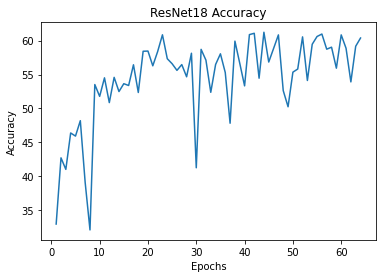

In [75]:
import matplotlib.pyplot as plt

x_axis = [i for i in range(1, epochs+1)]
plt.plot(x_axis, test_accuracies)

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('ResNet18 Accuracy')

plt.show()